In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '..')
from utils.models import RGCN_v1, gwnet_wrapper
#from utils.xai_utils import expected_gradients

plt.style.use('dark_background')
np.random.seed(123)
torch.manual_seed(123)

In [2]:

def expected_gradients(x, x_set, adj_matrix, model, n_samples, temporal_focus=None, spatial_focus=None):

    n_series = x_set.shape[0]
    n_segs = adj_matrix.shape[0]
    num_vars = x_set.shape[2]
    seq_len = x_set.shape[1]

    x_set_4D = x_set.reshape(n_series//n_segs,n_segs,seq_len,num_vars)

    for k in range(n_samples):
        # SAMPLE A RANDOM BASELINE INPUT
        baseline_x = torch.empty(n_segs, seq_len, num_vars).to(device).float()
        # for all segments
        for seg in range(n_segs):
            # pick one of the years
            seg_year = np.random.choice(n_series//n_segs)  #do we want to be sampling random segs or random years?
            # fill the baseline with a random year of data from each segment
            baseline_x[seg] = x_set_4D[seg_year, seg]

        # SAMPLE A RANDOM SCALE ALONG THE DIFFERENCE
        scale = np.random.uniform()

        # SAME IG CALCULATION
        x_diff = x - baseline_x
        curr_x = baseline_x + scale*x_diff
        if curr_x.requires_grad == False:
            curr_x.requires_grad = True
        model.zero_grad()
        y = model(curr_x)

        # GET GRADIENT
        if temporal_focus == None and spatial_focus == None:
            gradients = torch.autograd.grad(y[:, :, :], curr_x, torch.ones_like(y[:, :, :]))
        elif temporal_focus == None and spatial_focus != None:
            gradients = torch.autograd.grad(y[spatial_focus, :, :], curr_x, torch.ones_like(y[spatial_focus, :, :]))
        elif temporal_focus != None and spatial_focus == None:
            gradients = torch.autograd.grad(y[:, temporal_focus, :], curr_x, torch.ones_like(y[:, temporal_focus, :]))
        else:
            gradients = torch.autograd.grad(y[spatial_focus, temporal_focus, :], curr_x, torch.ones_like(y[spatial_focus, temporal_focus, :]))

        if k == 0:
            expected_gradients = x_diff*gradients[0] * 1/n_samples
        else:
            expected_gradients = expected_gradients + ((x_diff*gradients[0]) * 1/n_samples)

    return(expected_gradients.detach().cpu().numpy())


# Set up general arguments and pull in some real River-dl data

In [3]:
## Define some general arguments for the notebook
mod = 'GWN'  #GWN or RGCN
#base = 'mean' #zeros or mean
grad_steps = 500 #Number of steps to take in calculation of IG
year_index = -1 # Sequence to apply IG to
weights_file = f'../../river-dl/results/baseline/{mod}/rep_5/finetuned_weights.pth'
prepped_file = f"../../river-dl/results/baseline/{mod}/prepped.npz"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pred_length = 15

river_dl = np.load(prepped_file)
num_vars = len(river_dl['x_vars'])
seq_len = river_dl['x_trn'].shape[1]
adj_matrix = river_dl['dist_matrix']
n_segs = adj_matrix.shape[0]

x_full=torch.from_numpy(river_dl['x_trn']).to(device).float()
x=x_full[455*year_index:]
dates_x = river_dl['times_trn'][455*year_index:][0].flatten()


x.shape, x_full.shape, adj_matrix.shape

(torch.Size([455, 60, 7]), torch.Size([295750, 60, 7]), (455, 455))

In [4]:
if mod == 'RGCN':
    model = RGCN_v1(num_vars, 20, adj_matrix,device=device)
    model.load_state_dict(torch.load(weights_file, map_location=device))

elif mod == 'GWN':
    supports = [torch.tensor(adj_matrix).to(device).float()]
    out_dim = pred_length
    model = gwnet_wrapper(device,n_segs,supports=supports,aptinit=supports[0],
    in_dim=num_vars,out_dim=out_dim,layers=3, kernel_size=5,blocks=3, weights_path=weights_file,
                          nsegs=n_segs)
    
model.eval()
model.to(device)

gwnet_wrapper(
  (model): gwnet(
    (start_conv): Conv2d(7, 32, kernel_size=(1, 1), stride=(1, 1))
    (residual_convs): ModuleList(
      (0): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (1): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (2): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (3): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (4): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (5): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (6): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (7): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (8): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
    )
    (skip_convs): ModuleList(
      (0): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
      (1): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
      (2): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
      (3): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
      (4): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))

CPU times: user 18.3 s, sys: 2.38 s, total: 20.7 s
Wall time: 23.4 s


Text(0.5, 1.0, 'expected gradient values at one segment\nw.r.t. outputs at all space and time')

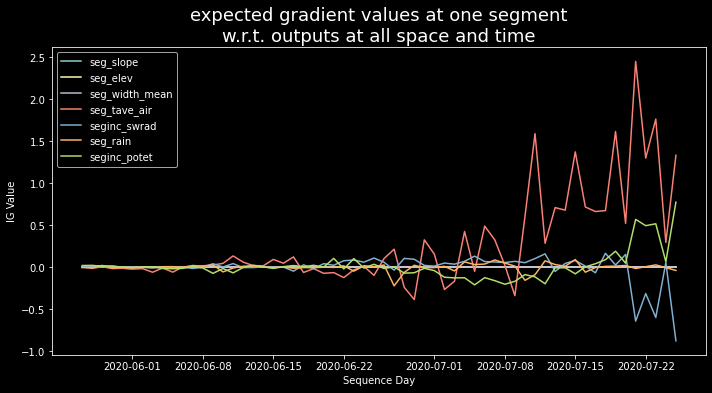

In [5]:
%%time
EG_vals = expected_gradients(x, x_full, adj_matrix, model, n_samples=grad_steps)

plt.figure(figsize = (10, 5))
for i in range(num_vars):
    plt.plot(dates_x, EG_vals[0, :, i], label = river_dl['x_vars'][i])
plt.legend(loc = 'upper left')
plt.xlabel('Sequence Day')
plt.ylabel('IG Value')
plt.tight_layout()
plt.title('expected gradient values at one segment\nw.r.t. outputs at all space and time',
          fontsize = 18)

606.9635

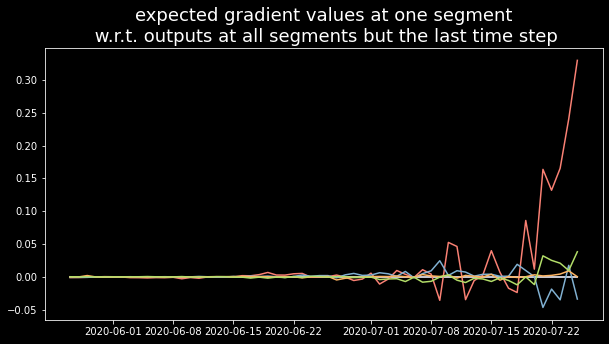

In [6]:
EG_vals = expected_gradients(x, x_full, adj_matrix, model, n_samples=grad_steps, temporal_focus = -1)

plt.figure(figsize = (10, 5))
for i in range(num_vars):
    plt.plot(dates_x, EG_vals[0, :, i])
plt.title('expected gradient values at one segment\n w.r.t. outputs at all segments but the last time step',
          fontsize = 18);

np.sum(EG_vals.flatten())

1.4301432

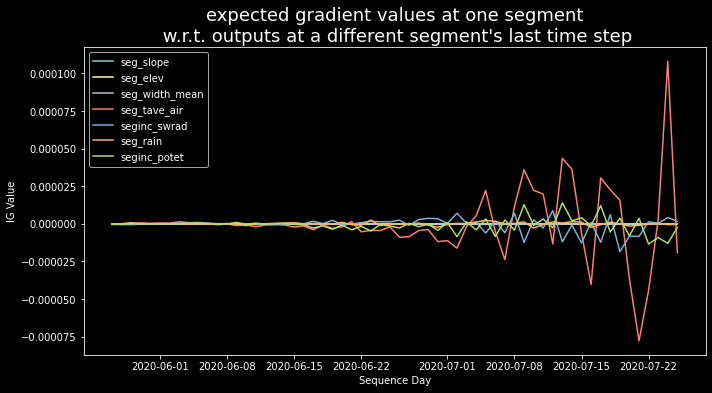

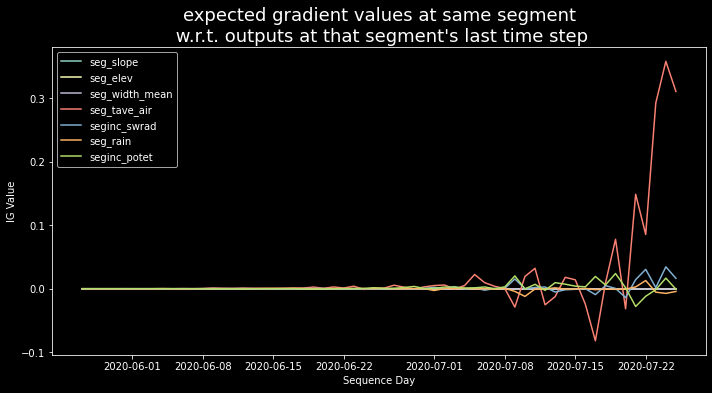

In [7]:
EG_vals = expected_gradients(x, x_full, adj_matrix, model, n_samples=grad_steps, temporal_focus = -1, spatial_focus = -1)

plt.figure(figsize = (10, 5))
for i in range(num_vars):
    plt.plot(dates_x, EG_vals[0, :, i],label = river_dl['x_vars'][i])
plt.legend(loc ='upper left')
plt.xlabel('Sequence Day')
plt.ylabel('IG Value')
plt.tight_layout()
plt.title("expected gradient values at one segment\n w.r.t. outputs at a different segment's last time step",
          fontsize = 18);

plt.figure(figsize = (10, 5))
for i in range(num_vars):
    plt.plot(dates_x, EG_vals[-1, :, i],label = river_dl['x_vars'][i])
plt.legend(loc = 'upper left')
plt.xlabel('Sequence Day')
plt.ylabel('IG Value')
plt.tight_layout()
plt.title("expected gradient values at same segment\n w.r.t. outputs at that segment's last time step",
          fontsize = 18);
np.sum(EG_vals.flatten())

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

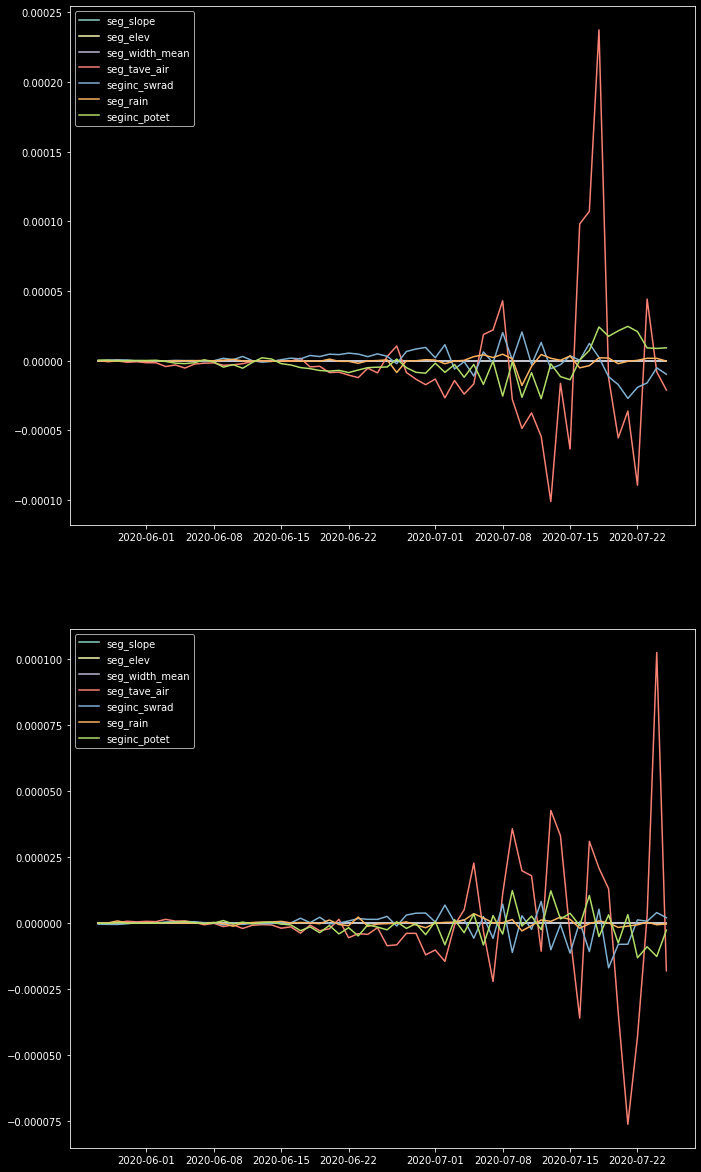

In [8]:
obs = range(1,pred_length, 7)
num_plots = len(obs)

fig, axes = plt.subplots(nrows=num_plots,figsize=(11.2,21))
for (ob,ax) in zip(reversed(obs),axes):
    attributions = expected_gradients(x, x_full, adj_matrix, model, n_samples=grad_steps, temporal_focus = -ob, spatial_focus = -1) # attributions for last day in the sequence
    for i in range(num_vars):
        ax.plot(dates_x,attributions[0, :, i], label = river_dl['x_vars'][i])
    ax.legend(loc = 'upper left')
plt.tight_layout

# Apply XAI and visualize - can we trust IG temporally?

When looking at what's important for the last time step's prediction, it appears that anything before the last 45 values don't matter. Let's do an experiment where we scramble those supposedly irrelevant values and see how it impacts predictions

In [9]:
EG_vals = expected_gradients(x, x_full, adj_matrix, model, n_samples=grad_steps, temporal_focus = -1)
np.sum(EG_vals.flatten())

611.51416

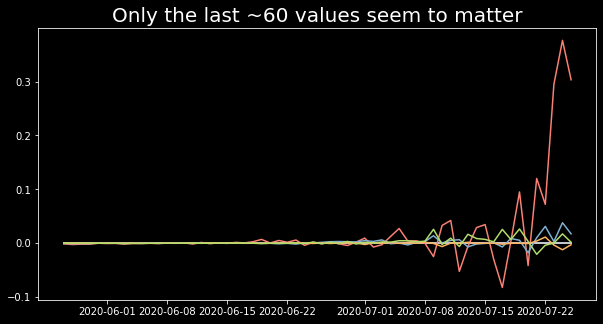

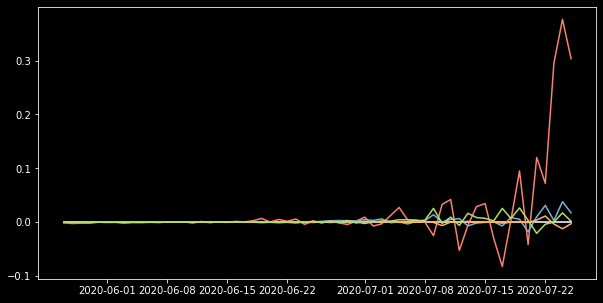

In [10]:
plt.figure(figsize = (10, 5))
plt.plot(dates_x, EG_vals[-1, :, :])
plt.title('Only the last ~60 values seem to matter', fontsize = 20)
plt.pause(0.001)
plt.figure(figsize = (10, 5))
plt.plot(dates_x[-60:], EG_vals[-1, -60:, :]);

In [11]:
 def compare_temporally_altered(first_n_days):
    y_hat_original = model(x)

    # replace first n out of 365 days with random values
    # and see how results change
    x_hypothesis = x.detach().clone()
    x_hypothesis[:, :first_n_days] = torch.rand_like(x[:, :first_n_days])
    y_hat_hypothesis = model(x_hypothesis)

    fig, ax = plt.subplots(3, 2, figsize = (12, 9))

    ax[0,0].plot(dates_x, x[0].detach().cpu(), color = 'white', alpha = 0.4)
    ax[0,0].set_ylim(-3, 5)
    ax[0,0].set_title('X Values')
    ax[0,1].plot(dates_x, x_hypothesis[0].detach().cpu(), color = 'white', alpha = 0.4)
    ax[0,1].set_ylim(-3, 5)
    ax[0,1].set_title('X Values Noised')
    ax[1,0].plot(y_hat_original[0].detach().cpu())
    ax[1,0].set_ylim(-1.5, 1.5)
    ax[1,0].set_title('Predicted Values')
    ax[1,1].plot(y_hat_hypothesis[0].detach().cpu())
    ax[1,1].set_ylim(-1.5, 1.5)
    ax[1,1].set_title('Predicted Noised')
    ax[2,0].plot(y_hat_original[0, :].detach().cpu())
    ax[2,0].plot(y_hat_hypothesis[0, :].detach().cpu())
    ax[2,0].set_title('Before and After Noise')
    ax[2,1].plot(y_hat_original[0, -60:].detach().cpu())
    ax[2,1].plot(y_hat_hypothesis[0, -60:].detach().cpu())
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

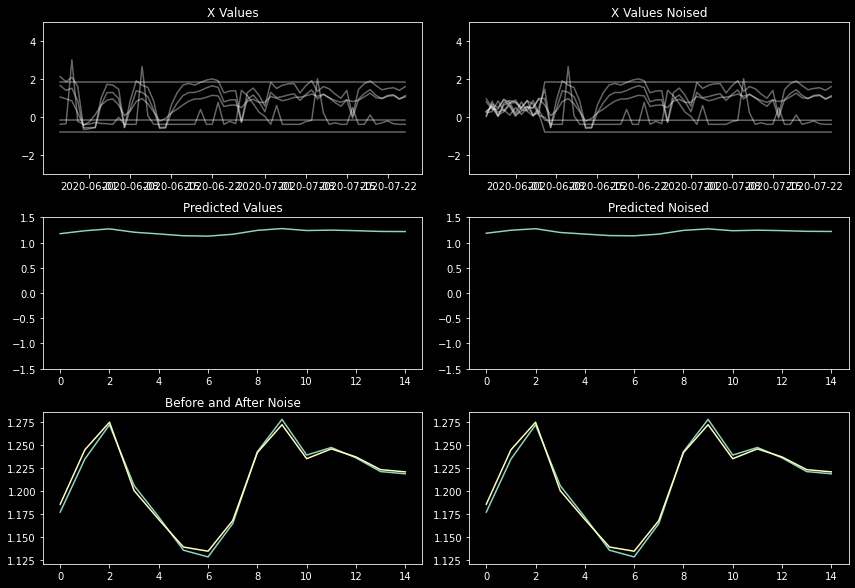

In [12]:
compare_temporally_altered(x.shape[1]-50)

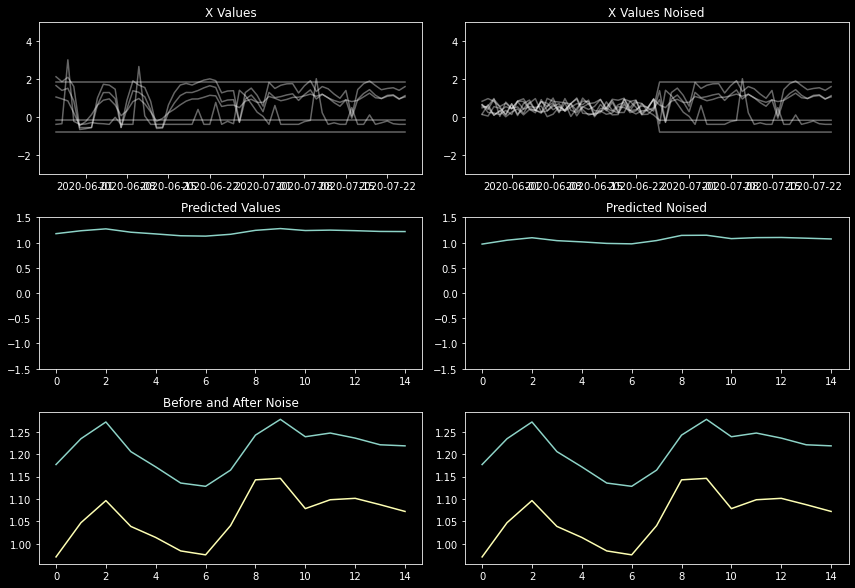

In [13]:
compare_temporally_altered(x.shape[1]-30)

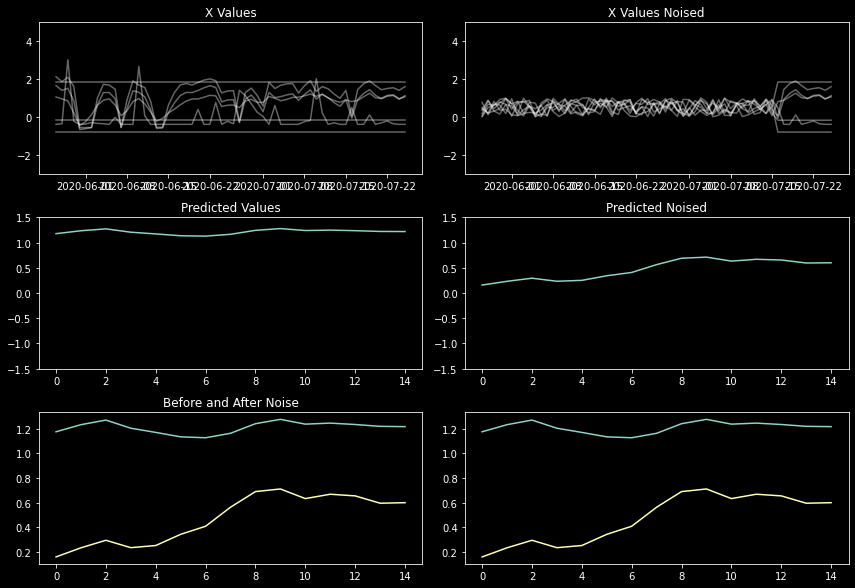

In [14]:
compare_temporally_altered(x.shape[1]-10)

The evidence appears to suggest that we can trust how IG explains importance temporally

# Apply XAI and visualize - can we trust IG spatially?

Similar experiment to the above, but seeing if we can trust what neighboring streams are identified as important

In [15]:
def compare_spatially_altered(seg_of_interest, important_segments, unimportant_segments):
    y_hat_original = model(x)

    x_hypothesis1 = x.detach().clone()
    for s in important_segments:
        x_hypothesis1[s] = torch.rand_like(x[s])
    y_hat_hypothesis1 = model(x_hypothesis1)

    x_hypothesis2 = x.detach().clone()
    for s in unimportant_segments:
        x_hypothesis2[s] = torch.rand_like(x[s])
    y_hat_hypothesis2 = model(x_hypothesis2)

    fig, ax = plt.subplots(5, figsize = (10, 30))

    for seg in important_segments:
        ax[0].plot(x[seg].detach().cpu(), color = 'white', alpha = 0.3)
        ax[1].plot(x_hypothesis1[seg].detach().cpu(), color = 'white', alpha = 0.5)
        ax[1].set_title('Changed segment variable values | important')

    for seg in unimportant_segments:
        ax[0].plot(x[seg].detach().cpu(), color = 'white', alpha = 0.3)
        ax[0].set_title('Unchanged segment variable')
        ax[2].plot(x_hypothesis2[seg].detach().cpu(), color = 'white', alpha = 0.5)
        ax[2].set_title('Changed segment variable values | unimportant')

    ax[3].set_title('Predictions under different scenarios')
    ax[3].plot(y_hat_original[seg_of_interest, :].detach().cpu(),
               label = 'Original')
    ax[3].plot(y_hat_hypothesis1[seg_of_interest, :].detach().cpu(),
               label = 'Important segments changed',
               linestyle = '--')
    ax[3].plot(y_hat_hypothesis2[seg_of_interest, :].detach().cpu(),
               label = 'Unimportant segments changed',
               linestyle = '--')
    ax[3].legend()

    ax[4].set_title('Difference in predictions')
    ax[4].plot(y_hat_original[seg_of_interest, :].detach().cpu() - y_hat_hypothesis1[seg_of_interest, :].detach().cpu(),
                 label = 'Important segments changed')
    ax[4].plot(y_hat_original[seg_of_interest, :].detach().cpu() - y_hat_hypothesis2[seg_of_interest, :].detach().cpu(),
                 label = 'Unimportant segments changed')
    ax[4].legend()

In [16]:
spatial_focus = np.random.choice(455)

EG_vals = expected_gradients(x, x_full, adj_matrix, model, n_samples=grad_steps, spatial_focus = spatial_focus)
most_relev = np.argsort(-np.sum(np.sum(np.abs(EG_vals), axis = 2), axis = 1))[1:5] # 1:5 because not itself
least_relev = np.argsort(-np.sum(np.sum(np.abs(EG_vals), axis = 2), axis = 1))[-5:]

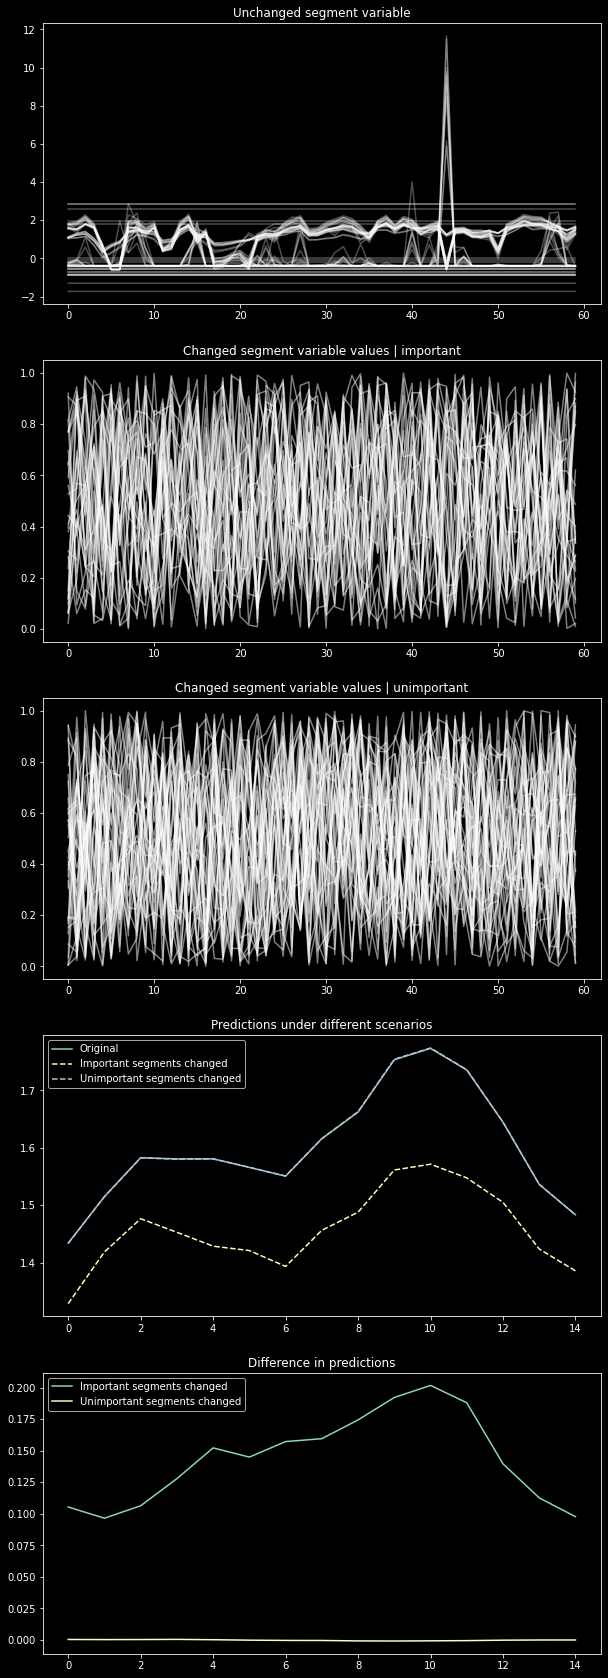

In [17]:
compare_spatially_altered(spatial_focus, most_relev, least_relev)

### A slightly more obvious difference in predictions

Spatial information doesn't seem to play a huge role, so hand-picking a more sensitive segment helps show the difference

In [18]:
spatial_focus = -1

EG_vals = expected_gradients(x, x_full, adj_matrix, model, n_samples=grad_steps, temporal_focus = -1, spatial_focus = spatial_focus)

most_relev = np.argsort(-np.sum(np.sum(np.abs(EG_vals), axis = 2), axis = 1))[1:5] # 1:5 because not itself
least_relev = np.argsort(-np.sum(np.sum(np.abs(EG_vals), axis = 2), axis = 1))[-5:]

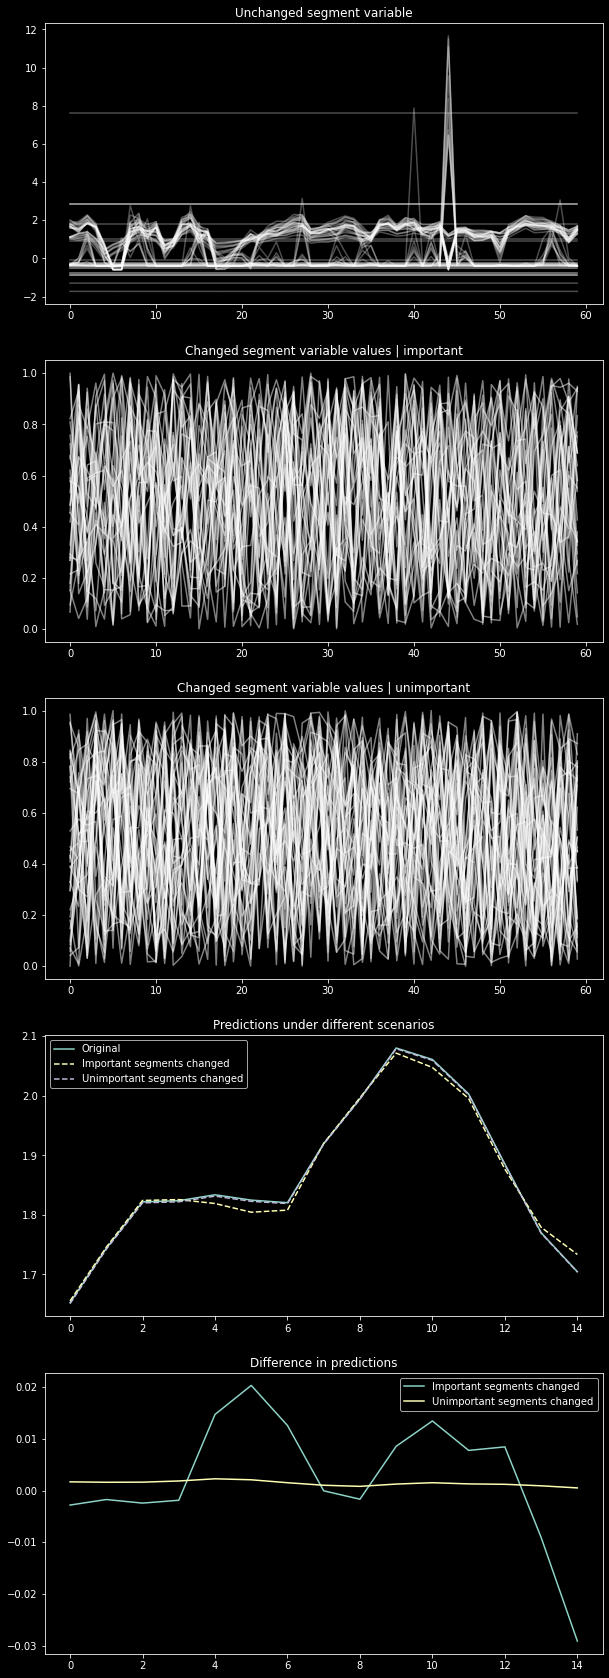

In [19]:
compare_spatially_altered(spatial_focus, most_relev, least_relev)

The evidence appears to suggest that we can trust how IG explains importance spatially

# Can we trust the feature importance?

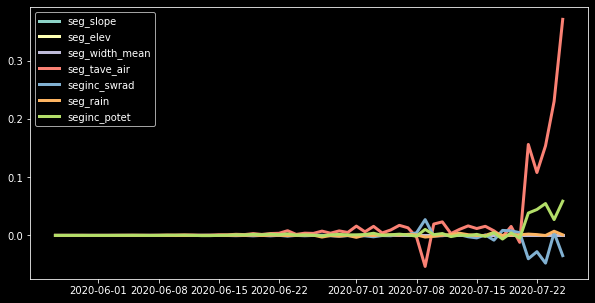

In [20]:
spatial_focus = 1 # has lots of observations

EG_vals = expected_gradients(x, x_full, adj_matrix, model, n_samples=grad_steps, temporal_focus = -1, spatial_focus = 1)

plt.figure(figsize = (10, 5))
for i in range(num_vars):
    plt.plot(dates_x, EG_vals[spatial_focus, :, i], label = river_dl['x_vars'][i], linewidth = 3)
#plt.xlim(, 180)
plt.legend(loc = 'upper left');

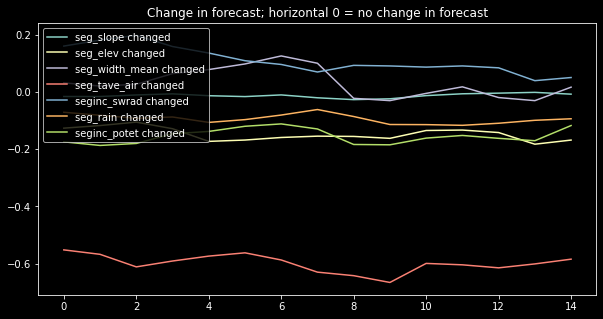

In [21]:
original_y_hat = model(x)

rmse_ls = []
plt.figure(figsize = (10, 5))

for i in range(num_vars):
    x_hypothesis = x.detach().clone()
    x_hypothesis[1, :, i] = torch.rand_like(x_hypothesis[1, :, i]) # change the variables

    y_hypothesis = model(x_hypothesis)

    plt.plot(y_hypothesis[1].detach().cpu() - original_y_hat[1].detach().cpu(), # view difference in forecast
             label = river_dl['x_vars'][i] + ' changed')
    #plt.xlim(80,180)
    plt.title('Change in forecast; horizontal 0 = no change in forecast')

plt.legend(loc = 'upper left');

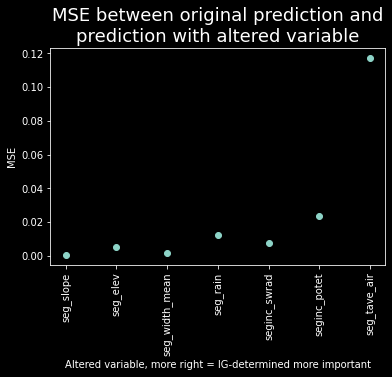

In [22]:
ordered_importance_of_vars = np.argsort(np.sum(np.abs(EG_vals[1]), axis = 0))

mse_ls = []
for var in ordered_importance_of_vars:
    x_hypothesis = x.detach().clone()
    x_hypothesis[1, :, var] = torch.rand_like(x_hypothesis[1, :, var])
    y_hypothesis = model(x_hypothesis)
    mse = torch.mean((y_hypothesis[1].detach() - original_y_hat[1].detach())**2).item()
    mse_ls.append(mse)

plt.scatter(range(len(mse_ls)), mse_ls)
plt.xticks(range(len(mse_ls)), labels = river_dl['x_vars'][ordered_importance_of_vars], rotation = 90)
plt.title('MSE between original prediction and\nprediction with altered variable', fontsize = 18)
plt.ylabel('MSE')
plt.xlabel('Altered variable, more right = IG-determined more important');

The experimental results line up pretty well (2 most important variables result in the most forecast change). Not entirely monotonic though, static features and 0-baseline could be playing a role

~~The experimental results line up pretty well (2 most important variables result in the most forecast change). Not entirely monotonic though, static features and 0-baseline could be playing a role~~

# Looking into why this might not be monotonicly increasing

First, seeing that the variables are ordered right. **Then, realize we're asigning random values between 0 and 1, this might be more or less change to different variables (i.e., maybe potet is already dynamic between 0 and 1, so the values aren't changed that much while tave_ss is dynamic between 9 and 10, so even though its less important, it's experiencing more change)** - a less exaggerated version of this does appear to be the case.

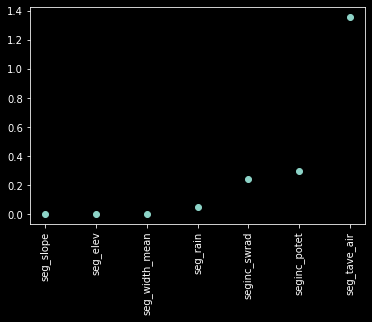

In [23]:
plt.scatter(range(len(mse_ls)), np.sum(np.abs(EG_vals[1]), axis = 0)[ordered_importance_of_vars])
plt.xticks(range(len(mse_ls)), labels = river_dl['x_vars'][ordered_importance_of_vars], rotation = 90);

In [24]:
ordered_importance_of_vars

array([0, 1, 2, 5, 4, 6, 3])

In [25]:
river_dl['x_vars'][3], x[-455:][1, :, 3].min(), x[-455:][1, :, 3].max()

('seg_tave_air',
 tensor(-0.4810, device='cuda:0'),
 tensor(1.2324, device='cuda:0'))

In [26]:
river_dl['x_vars'][4], x[-455:][1, :, 4].min(), x[-455:][1, :, 4].max()

('seginc_swrad',
 tensor(-0.5739, device='cuda:0'),
 tensor(2.0778, device='cuda:0'))

In [27]:
river_dl['x_vars'][6], x[-455:][1, :, 6].min(), x[-455:][1, :, 6].max()

('seginc_potet',
 tensor(-0.6460, device='cuda:0'),
 tensor(1.7545, device='cuda:0'))

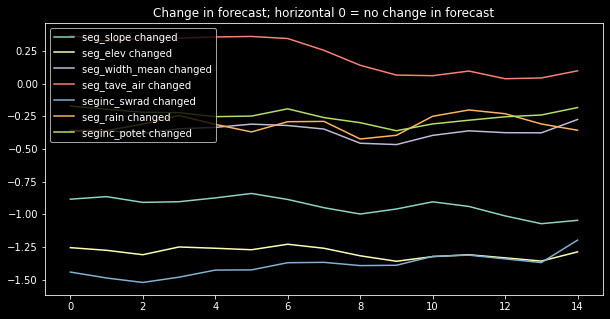

In [28]:
original_y_hat = model(x[-455:])

rmse_ls = []
plt.figure(figsize = (10, 5))

for i in range(len(river_dl['x_vars'])):
    x_hypothesis = x[-455:].detach().clone()
    x_hypothesis[1, :, i] = 9 + torch.rand_like(x_hypothesis[1, :, i]) # change the variables

    y_hypothesis = model(x_hypothesis)

    plt.plot(y_hypothesis[1].detach().cpu() - original_y_hat[1].detach().cpu(), # view difference in forecast
             label = river_dl['x_vars'][i] + ' changed')
    plt.title('Change in forecast; horizontal 0 = no change in forecast')

plt.legend(loc = 'upper left');

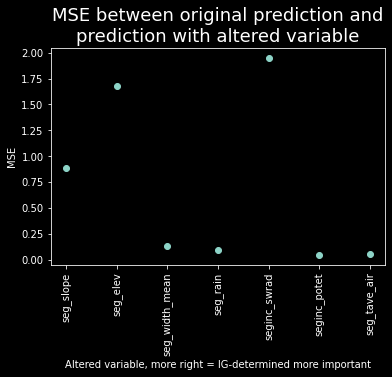

In [29]:
ordered_importance_of_vars = np.argsort(np.sum(np.abs(EG_vals[1]), axis = 0))

mse_ls = []
for var in ordered_importance_of_vars:
    x_hypothesis = x[-455:].detach().clone()
    x_hypothesis[1, :, var] = 9 + torch.rand_like(x_hypothesis[1, :, var])
    y_hypothesis = model(x_hypothesis)
    mse = torch.mean((y_hypothesis[1].detach().cpu() - original_y_hat[1].detach().cpu())**2).item()
    mse_ls.append(mse)

plt.scatter(range(len(mse_ls)), mse_ls)
plt.xticks(range(len(mse_ls)), labels = river_dl['x_vars'][ordered_importance_of_vars], rotation = 90)
plt.title('MSE between original prediction and\nprediction with altered variable', fontsize = 18)
plt.ylabel('MSE')
plt.xlabel('Altered variable, more right = IG-determined more important');

In [30]:
river_dl['x_vars'][1], x[-455:][1, :, 1].min(), x[-455:][1, :, 1].max()

('seg_elev', tensor(2.0917, device='cuda:0'), tensor(2.0917, device='cuda:0'))

In [31]:
river_dl['x_vars'][2], x[-455:][1, :, 2].min(), x[-455:][1, :, 2].max()

('seg_width_mean',
 tensor(-0.6110, device='cuda:0'),
 tensor(-0.6110, device='cuda:0'))

In [32]:
river_dl['x_vars'][4], x[-455:][1, :, 4].min(), x[-455:][1, :, 4].max()

('seginc_swrad',
 tensor(-0.5739, device='cuda:0'),
 tensor(2.0778, device='cuda:0'))

I feel much better about the explanations with that experiment. Ideally, we would want to change all the variables by some amount to get a more perfect version of this experience. E.g., alter variables that range from 0 and 1 to 9 and 10, alter variables that range from -2 and 2 to 8 and 12, etc... (something to that effect)

TLDR: for feature importance, it seems that the answers are still trustworthy, but this reveals that its less straightforward to verify that because you can't alter all variables to the same values because the values you alter them to may (if the same across all variables) better resemble the true values for some variables than others -> So, you might be altering a really important variable by very little, then be inclined to believe that the little change in forecast means your attribution was wrong